In [1]:
# OpenAI Gym
import gym_tetris as gym
import gym.spaces
import numpy as np
import keras

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output
import cv2

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.


In [2]:
env = gym.make('Tetris-v0')
downsize = (10,20)
observation=env.reset()

In [3]:
def resize(img,downsize):
    resized = cv2.resize(img,
                         dsize=downsize,
                         interpolation=cv2.INTER_CUBIC)
    return resized

In [4]:
resized_observation = resize(observation[17:423,7:212],downsize)
in_size = resized_observation.shape
obs_size = resized_observation.size
action_space = env.action_space.n
display(in_size)
display(obs_size)
display(action_space)

(20, 10, 3)

600

12

In [5]:
def make_model(state, action_size):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                                    input_shape=[state.shape[0],
                                                 state.shape[1],
                                                 state.shape[2]]))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.002))
    return model

model = make_model(resize(observation,downsize), 
                   action_space)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 8, 64)         1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 6, 64)         36928     
_________________________________________________________________
dense_1 (Dense)              (None, 16, 6, 64)         4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 6, 64)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 16, 6, 64)         4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                122900    
__________

In [6]:
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = [state_size.shape[0], state_size.shape[1], state_size.shape[2]]
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size, 
                                       self.state_size[0], 
                                       self.state_size[1], 
                                       self.state_size[2]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size, 
                                    self.state_size[0], 
                                    self.state_size[1],
                                    self.state_size[2]])
        self.done = [False]*memory_size # Boolean (terminal transition?)
        
    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            model_targets = model.predict(current_state)
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state,axis=1))

            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets

            # Update the weights accordingly
            model.fit(current_state,model_targets,
                      epochs=1,verbose=0,batch_size=sample_size)

        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [7]:
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1.0
epsilon2 = 0.2
epsilon_decay = 0.9997
epsilon_min = 0.05
episodes = 30000


replay_iterations = 100
replay_sample_size = 1024

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)
rewards = deque(maxlen=episodes)
epsilons = deque(maxlen=episodes)
max_Qs = deque(maxlen=episodes)
min_Qs = deque(maxlen=episodes)
avg_Qs = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('Tetris-v0')
observation = env.reset()
resized_obs = resize(observation[17:423,7:212],downsize)
model = make_model(resized_obs, action_space)
target_model = make_model(resized_obs, action_space)
memory = ReplayMemory(500000, resized_obs, action_space)

In [285]:
model.load_weights('weights.h5')
target_model.load_weights('target.h5')

In [68]:
#Run this when display surface quit
env = gym.make('Tetris-v0')
observation = env.reset()

In [89]:
model.save_weights('weights.h5')
target_model.save_weights('target.h5')

In [ ]:
done = False
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    current_state = current_state[17:423,7:212]
    time = 0
    total_reward = 0.0
    total_Q = 0
    max_Q=0
    min_Q=0
    height=0
    cleared=0
    while not done:
        time += 1
        Q = model.predict(np.expand_dims(resize(current_state, downsize), axis=0)) # Compute Q
        maxQ = Q[0][np.argmax(Q)]
        for i in range(0,action_space):
            Q[0][i] += maxQ
        action = np.random.choice(action_space) if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        next_height=info['height']
        if next_height > 10:
            done=True
        elif height < next_height:
            reward-=0.1*pow((next_height-height),2)
            height=next_height
        elif next_height < height:
            reward+=0.2*pow((next_height-height),2)
            height=next_height
            cleared+=1
        if done:
            reward -= 10.0
        total_reward += reward
        curr_Q = Q[0][action]-maxQ
        if curr_Q > max_Q:
            max_Q = curr_Q
        elif curr_Q < min_Q:
            min_Q = curr_Q
        total_Q += curr_Q
        if current_state.size == obs_size:
            resize_state = resize(current_state,downsize)
            memory.remember(resize_state, action,reward,next_state,done) # Store in memory...
        current_state = next_state[17:423,7:212] # Transition to next state!
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min 
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    epsilons.append(epsilon)
    max_Qs.append(max_Q)
    min_Qs.append(min_Q)
    avg_Q=total_Q/time
    avg_Qs.append(avg_Q)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f, reward: %g, Average Q: %g, Max Q: %g, Min Q: %g, Cleared: %d'%(episode+1,
                                                                                                                                 episodes,
                                                                                                                                 time,
                                                                                                                                 mean_time,
                                                                                                                                 epsilon,
                                                                                                                                 total_reward,
                                                                                                                                 avg_Q,
                                                                                                                                 max_Q,
                                                                                                                                 min_Q,
                                                                                                                                 cleared),end='')
    done = False
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

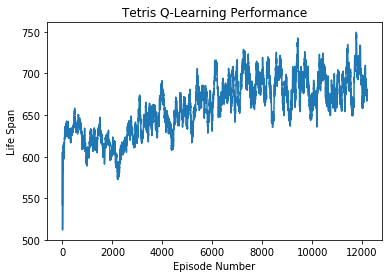

In [82]:
plt.plot(mean_times)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()

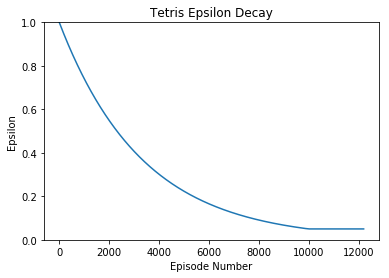

In [83]:
plt.plot(epsilons)
plt.ylim(top=1, bottom=0)
plt.title("Tetris Epsilon Decay")
plt.xlabel("Episode Number")
plt.ylabel("Epsilon")
plt.show()

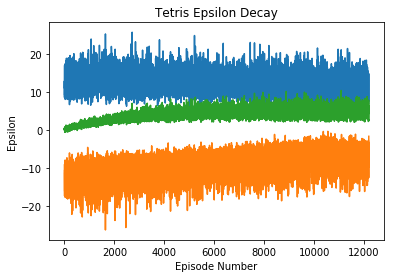

In [84]:
plt.plot(max_Qs)
plt.plot(min_Qs)
plt.plot(avg_Qs)
plt.title("Tetris Epsilon Decay")
plt.xlabel("Episode Number")
plt.ylabel("Epsilon")
plt.show()

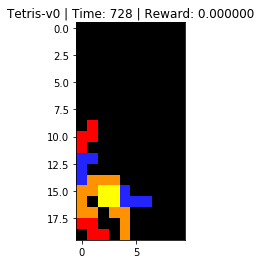

In [86]:
# Test out the agent!
# Initialize the environment and let the agent decide how to act!
env = gym.make('Tetris-v0')
observation = env.reset()
done = False
time = 0
reward = 0.0
while not done:
    observation = observation[17:423,7:212]
    obs = resize(observation,downsize)
    plt.imshow(obs)
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    Q = model.predict(np.expand_dims(obs,axis=0))
    action = np.argmax(Q)   
    observation, reward, done, info = env.step(action)
    next_height=info['height']
    if next_height > 10:
        break
    if (done):
        break
    time+=1
clear_output(wait=True)

In [87]:
done = False
result_times = deque(maxlen=25)
for episode in range(0,25):
    current_state = env.reset()
    current_state = current_state[17:423,7:212]
    result_time = 0
    while not done:
        result_time += 1
        Q = model.predict(np.expand_dims(resize(current_state, downsize), axis=0)) # Compute Q
        next_height=info['height']
        if next_height > 10:
            done = True
        action = np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        current_state = next_state[17:423,7:212] # Transition to next state!
    result_times.append(result_time)
    mean_result = np.mean(result_times)
    done = False
    print('\rRun: %d'%(episode+1),end='')
print('\nDone, mean-time: %d'%(mean_result))

Run: 25
Done, mean-time: 897


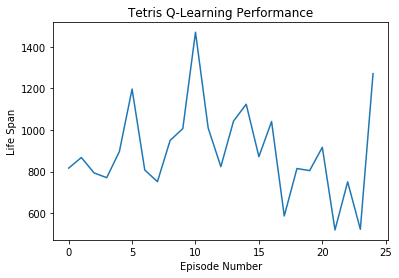

In [88]:
plt.plot(result_times)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()